<a href="https://colab.research.google.com/github/dabeyrathna/Capstone-Project-Bacteria-Cell-Segmentation/blob/main/unet_cell_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# root_path = 'gdrive/My Drive/bio_film'
root_path = 'gdrive/My Drive/Capstone project DDMD/UNET/'
os.chdir(root_path)

In [ ]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

## Seeding 
seed = 2022
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
    
    def __crop__(self, img, x1, x2, y1, y2):
      cropped_image = img[x1:x2, y1:y2]
      return cropped_image

    def __contrast__(self, img):
      lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
      l_channel, a, b = cv2.split(lab)

      # Applying CLAHE to L-channel
      # feel free to try different values for the limit and grid size:
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      cl = clahe.apply(l_channel)

      # merge the CLAHE enhanced L-channel with the a and b channel
      limg = cv2.merge((cl,a,b))

      # Converting image from LAB Color model to BGR color spcae
      enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
      return enhanced_img


    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = self.__contrast__(image)
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 128
train_path = "train"
val_path = "test"
epochs = 10
batch_size =8

## Training Ids
train_ids = next(os.walk(train_path))[1]
valid_ids = next(os.walk(val_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids#[val_data_size:]

In [ ]:
len(train_ids)
len(valid_ids)

10

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


(8, 128, 128, 3)


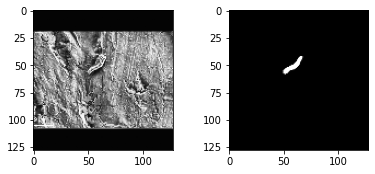

In [ ]:
# from re import I
x, y = gen.__getitem__(0)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(2): 
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(np.reshape(x[i], (image_size, image_size,3)), cmap="gray")  
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

print(x.shape)

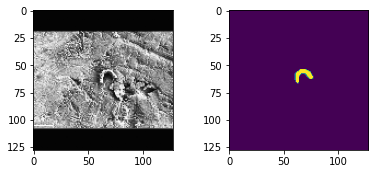

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="viridis")

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [8,16, 32, 64,128,256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
opt = tf.keras.optimizers.SGD(learning_rate=0.00005)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['conv2d_1[0][0]']           

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print(train_steps)

early_stopping_callback = EarlyStopping(monitor='loss', patience=3)

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,epochs=40, callbacks=[early_stopping_callback])

7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/40
7/7 [==============================] - 122s 14s/step - loss: 0.9299 - acc: 0.2912 - val_loss: 0.7015 - val_acc: 0.0413
Epoch 2/40
7/7 [==============================] - 11s 2s/step - loss: 0.9283 - acc: 0.2947 - val_loss: 0.7062 - val_acc: 0.0153
Epoch 3/40
7/7 [==============================] - 4s 619ms/step - loss: 0.9202 - acc: 0.2988 - val_loss: 0.7110 - val_acc: 0.0096
Epoch 4/40
7/7 [==============================] - 0s 31ms/step - loss: 0.9128 - acc: 0.3081 - val_loss: 0.7159 - val_acc: 0.0080
Epoch 5/40
7/7 [==============================] - 5s 545ms/step - loss: 0.9082 - acc: 0.3094 - val_loss: 0.7211 - val_acc: 0.0075
Epoch 6/40
7/7 [==============================] - 0s 36ms/step - loss: 0.8983 - acc: 0.3198 - val_loss: 0.7264 - val_acc: 0.0078
Epoch 7/40
7/7 [==============================] - 0s 35ms/step - loss: 0.8978 - acc: 0.3141 - val_loss: 0.7319 - val_acc: 0.0081
Epoch 8/40
7/7 [==============================] - 0s 32ms/step - loss: 0.8873 - acc: 0.3261 - v

In [ ]:
print(valid_gen.__len__())
print(valid_steps)

5
1


In [ ]:
## Save the Weights
model.save("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
# print(x,y)
result = model.predict(x)

result = result > 0.5

In [ ]:
x.shape

(2, 128, 128, 3)

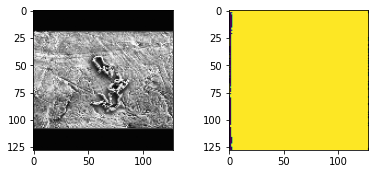

In [ ]:

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i=0
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(x[i], (image_size, image_size,3)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="viridis")